In [1]:
# !pip install -q -i https://bbpteam.epfl.ch/repository/devpi/simple/ bluepy --force-reinstall

In [23]:
import bluepy
import numpy
from matplotlib import pyplot as plt
from scipy import sparse
from scipy.stats import hypergeom
from scipy import spatial

circ_cfg = '/mnt/circuits/O1/20181114/CircuitConfig'
circ = bluepy.Circuit(circ_cfg).v2

In the first part of this exercise, we found that neurons in a local circuit tend to have more (graph-theoretical) "common neighbors" than expected, even when compared to a powerful control case. But Perin et al., 2011 found also another trend: Neuron pairs with many common neighbors are more likely to be connected to each other than pairs with few. In other words, the connection probability depends on the number of common neighbors of a pair.
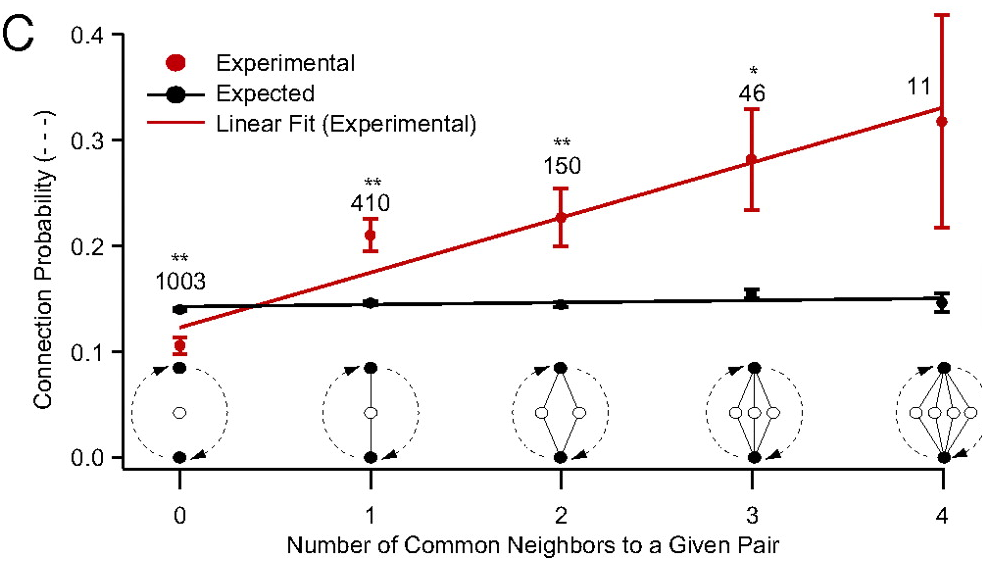

And as before, we will see if we can find this tendency in an in-silico hippocampal microcircuit. Once more, we want analyze this tendency on a much more global scale than sampling 8 neurons at a time. So to start we define the functions to generate the full efferent connectivity of a population and to calculate the matrix of common neighbor numbers from it, as before (see "Common neighbor analysis 1").

In [24]:
def efferent_con_mat(pop_gids):
    '''Returns a sparse matrix of the EFFERENT connectivity of neurons in
    the specified population'''
    shape = (len(pop_gids), len(circ.cells.get())) # The output shape is (number of neurons in population x number of neurons in circuit)
    
    post = [circ.connectome.efferent_gids(_g) - 1 # Get identifiers of connected neurons.
            for _g in pop_gids]                   # Subtract 1 because identifiers start at 1, but we need base 0 indices.
    '''prepare the sparse matrix representation, where the column indices for row i are stored in
    "indices[indptr[i]:indptr[i+1]]" and their corresponding values are stored in "data[indptr[i]:indptr[i+1]]".'''
    indptr = numpy.hstack((0, numpy.cumsum(map(len, post))))
    indices = numpy.hstack(post)
    data = numpy.ones_like(indices, dtype=bool) # Simple boolean connection matrix. A connection exists or not.
    return sparse.csr_matrix((data, indices, indptr), shape=shape)


Now for this example, we will do something slightly different. As mentioned, we want to see whether the connection probability increases with the number of common neighbors. But because connectivity is directed, we can go one step further: We can also analyze how this increase depends on the direction of the connection.
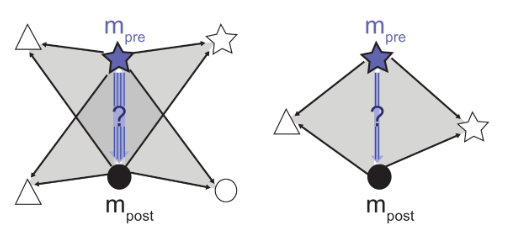

For this, we consider the number of common neighbors between two different populations, in the illustration above indicated by the blue star and the black circle. We can consider the number of commonn neighbors between pairs of neurons where one neuron is in the "star" population and the other in the "circle" population and then evaluate separately how this influences the connection probability from star to circle and from circle to star.

Here, we use the excitatory and inhibitory sub-populations.

In [25]:
analyze_population1 = 'Excitatory'
analyze_population2 = 'Inhibitory'
n_smpl_population = 2500
analyze_gids1 = numpy.random.choice(circ.cells.ids(analyze_population1),
                                    n_smpl_population, replace=False)
analyze_gids1.sort()
analyze_gids2 = circ.cells.ids(analyze_population2)

connections1 = efferent_con_mat(analyze_gids1)
connections2 = efferent_con_mat(analyze_gids2)

print connections1.shape, connections2.shape


(2500, 18186) (1326, 18186)


Because we can calculate the number of common neighbors with a matrix multiplication, we have to change the code very little. Simply instead of multiplying a connection matrix with its transpose, we multiply one matrix with the transpoe other. The result is a matrix of the number of common neighbors for all pairs of the two populations.

(2500, 1326)


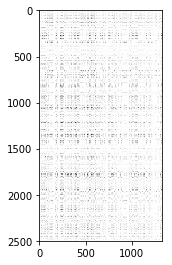

In [26]:
def common_efferent_neighbors(M, *args):
    if len(args) == 0: # No second matrix provided: Default to the early use case, com. neighs. within the population
        return common_efferent_neighbors(M, M)
    M2 = args[0]
    assert M.shape[1] == M2.shape[1]
    CN = M.astype(int) * M2.astype(int).transpose() # Our new use case: com. neighs. for pairs of the two populations
    return CN.toarray()

com_neighs = common_efferent_neighbors(connections1, connections2)
print com_neighs.shape
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.imshow(com_neighs, cmap='Greys')

Unlike earlier, this matrix is no longer symmetrical and it does not have the large entries along the main diagonal. This is because the two populations are disjunct, so we never evaluate the number of common neighbors between a neuron and itself.

Next, we need the connectivity between the two defined populations. Luckily, we already have the connectivity from population1 to everything (and also from population2 to everything), so we can get the required connection matrices as a sub-matrices of that. We will get two such matrices, one each for the analysis of increased connection probability in either direction.

In [27]:
con_1_to_2 = connections1[:, analyze_gids2 - 1] # minus 1 because neuron gids start counting at 0.
con_2_to_1 = connections2[:, analyze_gids1 - 1].transpose() # transpose because we need population 1 to be along the first axis.
print con_between.shape, sanity_check.shape

(2500, 1326) (2500, 1326)


With all of this, we can now plot how the connection probability in either direction depends on the number of common neighbors between pairs of neurons of the two populations. We define a minimum of 10 connections to be sampled to establish a proper probability.

<type 'numpy.ndarray'> <class 'scipy.sparse.csr.csr_matrix'>
1530 1212
<type 'numpy.ndarray'> <class 'scipy.sparse.csc.csc_matrix'>
1530 1212


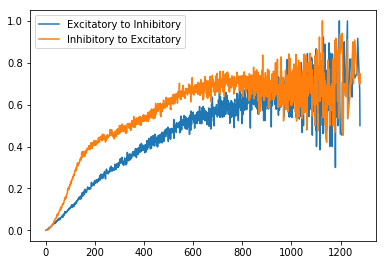

In [31]:
def con_prob_for_common_neighbors(cn_mat, connections, min_connections=10):
    cn_x = numpy.unique(cn_mat)
    smpls = [connections[cn_mat == i] for i in cn_x]
    result = [(x, y.mean()) for x, y in zip(cn_x, smpls)
              if numpy.prod(y.shape) >= min_connections]
    return zip(*result)

x1, y1 = con_prob_for_common_neighbors(com_neighs, con_1_to_2)
x2, y2 = con_prob_for_common_neighbors(com_neighs, con_2_to_1)
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x1, y1, label='%s to %s' % (analyze_population1, analyze_population2))
ax.plot(x2, y2, label='%s to %s' % (analyze_population2, analyze_population1))
ax.legend()
    

As we can see, the way the number of common neighbors affects the connection probability indeed does depend on the direction of the connection: for common neighbor numbers under 200 there is a much stronger increase for inhibitory to excitatory, but eventually it flattens out and both directions end up at a value around 0.7.

Now, with this analysis, we once again have to compare to a powerful control. This time we go directly for the control preserving the distance dependence.

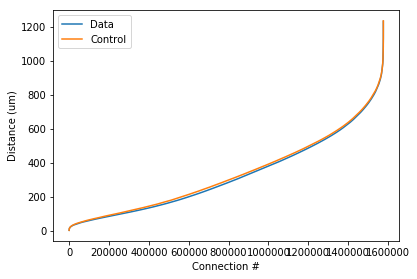

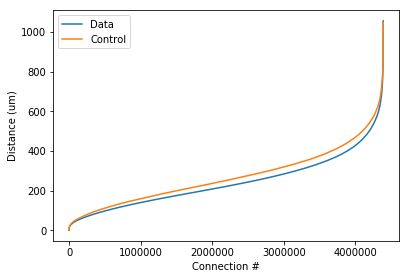

In [39]:
nbins = 50

def connect_keep_dist_dep(D, C, nbins):
    '''Randomly connect a number of neurons, keeping their distance dependence intact.
    D: Matrix (AxN) of distances to all other neurons in the circuit
    C: Matrix (AxN) of connections to all other neurons in the circuit (boolean)'''
    dbins = numpy.linspace(0, D.max(), nbins + 1) + 0.1
    Di = numpy.digitize(D, bins=dbins) - 1
    H_connected = numpy.histogram(Di[C.toarray()], bins=range(nbins + 1))[0]
    H_all = numpy.histogram(Di, bins=range(nbins + 1))[0]
    P = H_connected.astype(float) / H_all
    n_eff = numpy.array(C.sum(axis=1)).transpose()[0]
    indptr = [0]
    indices = []
    for row, n in zip(Di, n_eff):
        p_row = P[row]
        p_row[row == -1] = 0
        p_row = p_row / p_row.sum()
        rnd = numpy.random.choice(len(row), n, replace=False, p=p_row)
        indices.extend(rnd)
        indptr.append(indptr[-1] + n)
    data = numpy.ones_like(indices, dtype=bool)
    return sparse.csr_matrix((data, indices, indptr), shape=D.shape)

xyz = circ.cells.get(properties=['x', 'y', 'z'])
# get distance matrix as an input
D1 = spatial.distance_matrix(xyz.loc[analyze_gids1], xyz)
D2 = spatial.distance_matrix(xyz.loc[analyze_gids2], xyz)

rnd_connections1 = connect_keep_dist_dep(D1, connections1, nbins)
rnd_connections2 = connect_keep_dist_dep(D2, connections2, nbins)

# compare distribution of distances of connected neurons
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(sorted(D1[connections1.toarray()]), label='Data')
ax.plot(sorted(D1[rnd_connections1.toarray()]), label='Control')
ax.legend(); ax.set_xlabel('Connection #'); ax.set_ylabel('Distance (um)')

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(sorted(D2[connections2.toarray()]), label='Data')
ax.plot(sorted(D2[rnd_connections2.toarray()]), label='Control')
ax.legend(); ax.set_xlabel('Connection #'); ax.set_ylabel('Distance (um)')

<type 'numpy.ndarray'> <class 'scipy.sparse.csr.csr_matrix'>
1171 943
<type 'numpy.ndarray'> <class 'scipy.sparse.csc.csc_matrix'>
1171 943


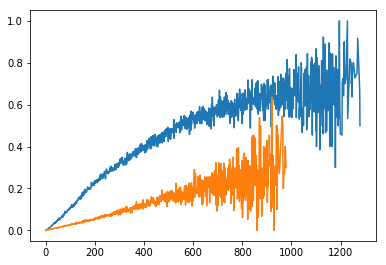

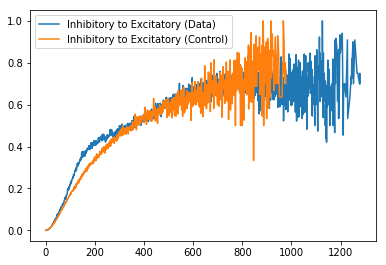

In [40]:
rnd_com_neighs = common_efferent_neighbors(rnd_connections1, rnd_connections2)
rnd_con_1_to_2 = rnd_connections1[:, analyze_gids2 - 1]
rnd_con_2_to_1 = rnd_connections2[:, analyze_gids1 - 1].transpose()
rnd_x1, rnd_y1 = con_prob_for_common_neighbors(rnd_com_neighs, rnd_con_1_to_2)
rnd_x2, rnd_y2 = con_prob_for_common_neighbors(rnd_com_neighs, rnd_con_2_to_1)

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x1, y1, label='%s to %s (Data)' % (analyze_population1, analyze_population2))
ax.plot(rnd_x1, rnd_y1, label='%s to %s (Control)' % (analyze_population1, analyze_population2))
ax.legend()

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x2, y2, label='%s to %s (Data)' % (analyze_population2, analyze_population1))
ax.plot(rnd_x2, rnd_y2, label='%s to %s (Control)' % (analyze_population2, analyze_population1))
ax.legend()

We see that the bias for increased connectivity between neurons with many common neighbors is better explained by the control in one direction than the other. The effect is much stronger from excitatory to inhibitory. Fascinating!